### **Import Library**

In [1]:
# ===== Torch Library ===== #
import torch
import torchvision 
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ===== etc ===== #
import numpy as np
import pandas as pd

import argparse

import matplotlib.pyplot as plt

from model import Embedding, Net
from test import test_single, test_multi
from graph import plot_r2, plot_r2_comb

### **Dataset**

In [2]:
def normalize(a):
    return (a-a.min(dim=0)[0])/(a.max(dim=0)[0]-a.min(dim=0)[0])
    

sleep_dir = './Dataset/user_sleep_2020.csv'

feature_category = [
    'startDt', 'endDt', 'lastUpdate',
    'wakeupduration', 'wakeupcount', 'durationtosleep', 'durationtowakeup',
    'lightsleepduration', 'deepsleepduration', 'remsleepduration',
    'hr_average', 'hr_min', 'hr_max', 'rr_average', 'rr_min', 'rr_max', 'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount'
]
len_categories = [3, 4, 3, 9]
num_features = [
                [0, 1, 2],
                [3, 6, 7, 9],
                [4, 5, 8],
                [10, 11, 12, 13, 14, 15, 16, 17, 18]
            ]

sleep_df = pd.read_csv(sleep_dir)
sleep_df[['startDt', 'endDt', 'lastUpdate']] = sleep_df[['startDt', 'endDt', 'lastUpdate']]/60

sleep_data, sleep_label = sleep_df.iloc[:,3:-1], sleep_df.iloc[:,-1]
partitioned_sleep_data, partitioned_sleep_label = sleep_df.iloc[:,3:-1][feature_category], sleep_df.iloc[:,-1]

sleep_data = normalize(torch.Tensor(sleep_data.values).to(torch.float32))
sleep_label = torch.Tensor(sleep_label.values).to(torch.float32).unsqueeze(1)

partitioned_sleep_data = normalize(torch.Tensor(partitioned_sleep_data.values).to(torch.float32))
partitioned_sleep_label = torch.Tensor(partitioned_sleep_label.values).to(torch.float32).unsqueeze(1)

rand_idx = torch.randperm(len(sleep_data))

sleep_data, sleep_label = sleep_data[rand_idx], sleep_label[rand_idx]
partitioned_sleep_data, partitioned_sleep_label = partitioned_sleep_data[rand_idx], partitioned_sleep_label[rand_idx]
print(sleep_data.shape, sleep_label.shape)

in_dim, out_dim = sleep_data.shape[1], 1

torch.Size([615, 19]) torch.Size([615, 1])


In [3]:
normal_dataset = torch.utils.data.TensorDataset(sleep_data, sleep_label)
partitioned_dataset = torch.utils.data.TensorDataset(partitioned_sleep_data, partitioned_sleep_label)

dataset_size = len(normal_dataset)
train_size = int(len(normal_dataset) * 0.8)
val_size = int(dataset_size * 0.1)
test_size = dataset_size - (train_size + val_size)

_,_, normal_test_set = torch.utils.data.random_split(normal_dataset, [train_size, val_size, test_size])
_,_, partitioned_test_set = torch.utils.data.random_split(partitioned_dataset, [train_size, val_size, test_size])

In [4]:
marker_list = ['o', 's', '*', 'x', 'D', '+']
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


def plot_r2(reg_acces, n_acces, mn_acces, p_acces, mp_acces, list_var):
    plt.figure(figsize=(15, 7))
    
    plt.plot(list_var, reg_acces, 'o-', color = color_list[0], label = 'Ideal')
    plt.plot(list_var, mp_acces, 's-', color = color_list[3], label = 'Multi modal w/ ED')
    plt.plot(list_var, mn_acces, 's--', color = color_list[3], label = 'Single modal w/ ED')
    plt.plot(list_var, p_acces, 'H-', color = color_list[4], label = 'Multi modal w/o ED')
    plt.plot(list_var, n_acces, 'H--', color = color_list[4], label = 'Single modal w/o ED')
    
    plt.xticks(list_var)
    plt.xlabel('Probability of Modal Imputation', fontsize=13)
    plt.ylabel('$R^2 Score$', fontsize=13)
    plt.grid()
    plt.legend(fontsize=13)

    plt.show()


def plot_r2_comb(n_acces, mn_acces, p_acces, mp_acces, list_var):
    plt.figure(figsize=(15, 7))
    plt.plot(list_var, n_acces, '*-', label = 'Single modal w/o ED')
    plt.plot(list_var, mn_acces, 's-', label = 'Single modal w/ ED')
    plt.plot(list_var, p_acces, 'h-', label = 'Multi modal w/o ED')
    plt.plot(list_var, mp_acces, 'H-', label = 'Multi modal w/ ED')
    
    plt.xticks(list_var, fontsize=12)
    plt.xlabel('Combination of Modal Imputation', fontsize=13)
    plt.ylabel('$R^2 Score$', fontsize=13)
    plt.grid()
    plt.legend(fontsize=13)

    plt.show()

### **Test 1) 모달 결손 확률에 따른 검증 $R^2$ 성능**

threshold: 0.05
threshold: 0.1
threshold: 0.15
threshold: 0.2
threshold: 0.25
threshold: 0.3


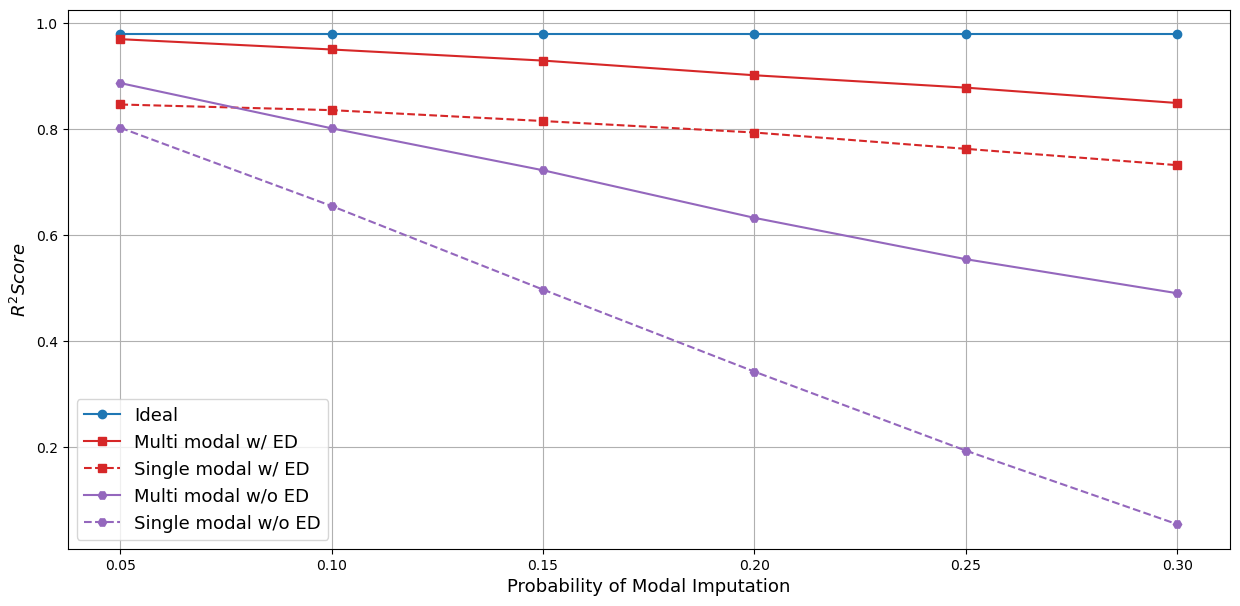

In [9]:
seed = 122812
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()

########################  Partitioned Hyper Parameters  ########################
args_ideal = parser.parse_args("")
args_ideal.exp_name = 'Single modal'
args_ideal.mask = False

# ====== Model Capacity ====== #
args_ideal.in_dim = in_dim
args_ideal.out_dim = out_dim
args_ideal.hid_dim = 183
args_ideal.act = 'relu'
args_ideal.n_layer = 3

# ====== Regularization ======= #
args_ideal.use_bn = True
args_ideal.use_xavier = True  

# ====== Training Params ====== #
args_ideal.train_batch_size = 64
args_ideal.test_batch_size = 64

args_ideal.threshold = 0
args_ideal.t = 0


########################  Partitioned Hyper Parameters  ########################
args_sm = parser.parse_args("")
args_sm.exp_name = 'Single modal'
args_sm.len_categories = [1 for i in range(in_dim)]
args_sm.mask = True

# ====m== Model Capacity ====== #
args_sm.in_dim = in_dim
args_sm.out_dim = out_dim
args_sm.hid_dim = 183
args_sm.act = 'relu'
args_sm.n_layer = 3

# ====m== Regularization ======= #
args_sm.use_bn = True
args_sm.use_xavier = True 

# ====m== Training Params ====== #
args_sm.train_batch_size = 64
args_sm.test_batch_size = 64

args_sm.threshold = 0
args_sm.t = 0


########################  Partitioned Hyper Parameters  ########################
args_EDsm = parser.parse_args("")
args_EDsm.exp_name = 'ED/Single modal'
args_EDsm.len_categories = [1 for i in range(in_dim)]
args_EDsm.mask = True

# ====== Model Capacity ====== #
args_EDsm.in_dim = in_dim
args_EDsm.out_dim = out_dim
args_EDsm.hid_dim = 183
args_EDsm.act = 'relu'
args_EDsm.n_layer = 3

# ====== Regularization ======= #
args_EDsm.use_bn = True
args_EDsm.use_xavier = True 

# ====== Training Params ====== #
args_EDsm.train_batch_size = 64
args_EDsm.test_batch_size = 64

args_EDsm.threshold = 0
args_EDsm.t = 0.2


########################  Partitioned Hyper Parameters  ########################
args_mm = parser.parse_args("")
args_mm.exp_name = 'Multi modal'
args_mm.len_categories = [3, 4, 3, 9]

# ====== Model Capacity ====== #
args_mm.in_dim = in_dim
args_mm.emb_dim = 50
args_mm.emb_n_layer = 1

args_mm.out_dim = out_dim
args_mm.hid_dim = 230
args_mm.act = 'relu'
args_mm.n_layer = 2

# ====== Regularization ======= #
args_mm.use_bn = True
args_mm.use_xavier = True  

# ====== Training Params ====== #
args_mm.train_batch_size = 64
args_mm.test_batch_size = 64

args_mm.threshold = 0
args_mm.t = 0


########################  Partitioned Hyper Parameters  ########################
args_EDmm = parser.parse_args("")
args_EDmm.exp_name = 'ED/Multi modal'
args_EDmm.len_categories = [3, 4, 3, 9]

# ====== Model Capacity ====== #
args_EDmm.in_dim = in_dim
args_EDmm.emb_dim = 50
args_EDmm.emb_n_layer = 1

args_EDmm.out_dim = out_dim
args_EDmm.hid_dim = 230
args_EDmm.act = 'relu'
args_EDmm.n_layer = 2

# ====== Regularization ======= #
args_EDmm.use_bn = True
args_EDmm.use_xavier = True  

# ====== Training Params ====== #
args_EDmm.train_batch_size = 64
args_EDmm.test_batch_size = 64

args_EDmm.threshold = 0
args_EDmm.t = 0.2


partition = {'Single modal':normal_test_set, 'ED/Single modal':normal_test_set, 'Multi modal':partitioned_test_set, 'ED/Multi modal':partitioned_test_set}

name_var = 'threshold'
list_var = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


ideal_acces, sm_acces, EDsm_acces, mm_acces, EDmm_acces = [], [], [], [], []


for var in list_var:
    setattr(args_ideal, name_var, var)
    setattr(args_sm, name_var, var)
    setattr(args_EDsm, name_var, var)
    setattr(args_mm, name_var, var)
    setattr(args_EDmm, name_var, var)
    print(f"{name_var}: {var}")
    
    temp_ideal_acces, temp_sm_acces, temp_EDsm_acces, temp_mm_acces, temp_EDmm_acces = [], [], [], [], []

    for seed in np.arange(0, 100000, 2000):
        seed = seed
        np.random.seed(seed)
        torch.manual_seed(seed)

        _, ideal_acc = test_single(partition, args_ideal)
        _, sm_acc = test_single(partition, args_sm)
        _, EDsm_acc = test_single(partition, args_EDsm)
        _, mm_acc = test_multi(partition, args_mm)
        _, EDmm_acc = test_multi(partition, args_EDmm)


        temp_ideal_acces.append(ideal_acc)
        temp_sm_acces.append(sm_acc)
        temp_EDsm_acces.append(EDsm_acc)
        temp_mm_acces.append(mm_acc)
        temp_EDmm_acces.append(EDmm_acc)

    ideal_acces.append(np.mean(temp_ideal_acces))
    sm_acces.append(np.mean(temp_sm_acces))
    EDsm_acces.append(np.mean(temp_EDsm_acces))
    mm_acces.append(np.mean(temp_mm_acces))
    EDmm_acces.append(np.mean(temp_EDmm_acces))


plot_r2(ideal_acces, sm_acces, EDsm_acces, mm_acces, EDmm_acces, list_var)

### **Test 2) 특정 결손 상황의 검증 $R^2$ 성능**

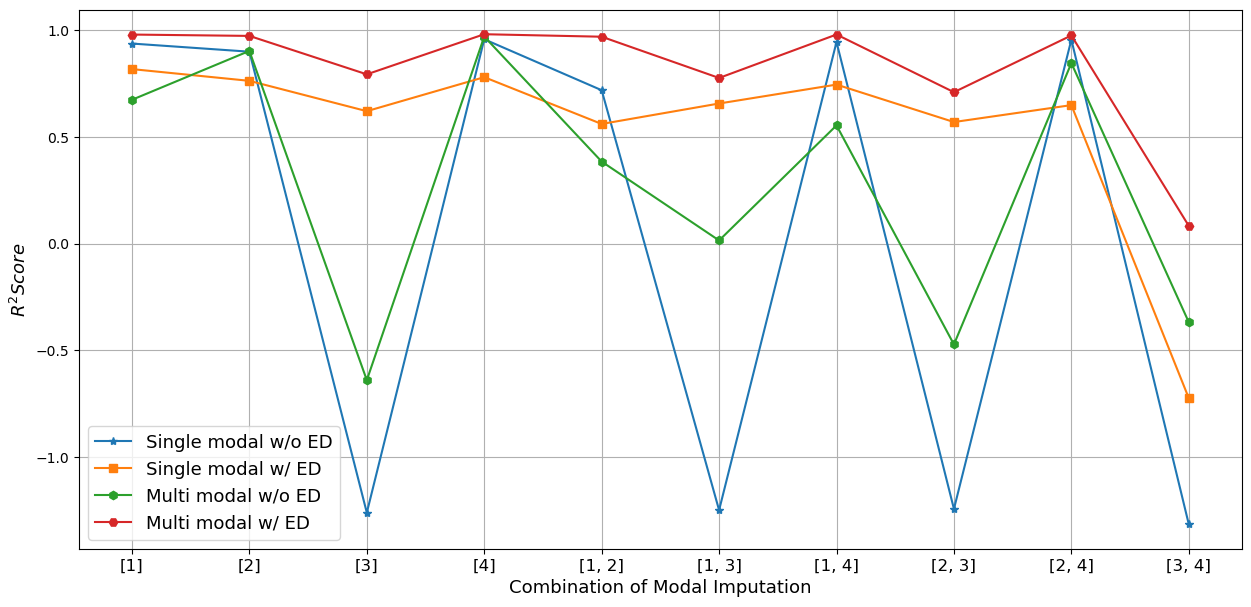

In [8]:
seed = 12281
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()


########################  Partitioned Hyper Parameters  ########################
args_sm = parser.parse_args("")
args_sm.exp_name = 'Single modal'
args_sm.len_categories = [3, 4, 3, 9]
args_sm.num_features = num_features
args_sm.mask = True

# ====== Model Capacity ====== #
args_sm.in_dim = in_dim
args_sm.out_dim = out_dim
args_sm.hid_dim = 183
args_sm.act = 'relu'
args_sm.n_layer = 3

# ====== Regularization ======= #
args_sm.use_bn = True
args_sm.use_xavier = True 

# ====== Training Params ====== #
args_sm.train_batch_size = 64
args_sm.test_batch_size = 64

args_sm.threshold = 0.2
args_sm.t = 0
args_sm.except_emb = 0


########################  Partitioned Hyper Parameters  ########################
args_EDsm = parser.parse_args("")
args_EDsm.exp_name = 'ED/Single modal'
args_EDsm.len_categories = [3, 4, 3, 9]
args_EDsm.num_features = num_features
args_EDsm.mask = True

# ====== Model Capacity ====== #
args_EDsm.in_dim = in_dim
args_EDsm.out_dim = out_dim
args_EDsm.hid_dim = 183
args_EDsm.act = 'relu'
args_EDsm.n_layer = 3

# ====== Regularization ======= #
args_EDsm.use_bn = True
args_EDsm.use_xavier = True 

# ====== Training Params ====== #
args_EDsm.train_batch_size = 64
args_EDsm.test_batch_size = 64

args_EDsm.threshold = 0.2
args_EDsm.t = 0.2
args_EDsm.except_emb = 0


########################  Partitioned Hyper Parameters  ########################
args_mm = parser.parse_args("")
args_mm.exp_name = 'Multi modal'
args_mm.len_categories = [3, 4, 3, 9]

# ====== Model Capacity ====== #
args_mm.in_dim = in_dim
args_mm.emb_dim = 50
args_mm.emb_n_layer = 1

args_mm.out_dim = out_dim
args_mm.hid_dim = 230
args_mm.act = 'relu'
args_mm.n_layer = 2

# ====== Regularization ======= #
args_mm.use_bn = True
args_mm.use_xavier = True  

# ====== Training Params ====== #
args_mm.train_batch_size = 64
args_mm.test_batch_size = 64

args_mm.threshold = 0.2
args_mm.t = 0
args_mm.except_emb = 0


########################  Partitioned Hyper Parameters  ########################
args_EDmm = parser.parse_args("")
args_EDmm.exp_name = 'ED/Multi modal'
args_EDmm.len_categories = [3, 4, 3, 9]

# ====== Model Capacity ====== #
args_EDmm.in_dim = in_dim
args_EDmm.emb_dim = 50
args_EDmm.emb_n_layer = 1

args_EDmm.out_dim = out_dim
args_EDmm.hid_dim = 230
args_EDmm.act = 'relu'
args_EDmm.n_layer = 2

# ====== Regularization ======= #
args_EDmm.use_bn = True
args_EDmm.use_xavier = True  

# ====== Training Params ====== #
args_EDmm.train_batch_size = 64
args_EDmm.test_batch_size = 64

args_EDmm.threshold = 0.2
args_EDmm.t = 0.2
args_EDmm.except_emb = 0


partition = {'Single modal':normal_test_set, 'ED/Single modal':normal_test_set, 'Multi modal':partitioned_test_set, 'ED/Multi modal':partitioned_test_set}

name_var = 'except_emb'
list_var = [[0], [1], [2], [3], [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
str_list_var = [str(a) for a in [[1], [2], [3], [4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]]


sm_acces, EDsm_acces, mm_acces, EDmm_acces = [], [], [], []


for var in list_var:
    setattr(args_sm, name_var, var)
    setattr(args_EDsm, name_var, var)
    setattr(args_mm, name_var, var)
    setattr(args_EDmm, name_var, var)
    

    temp_sm_acces, temp_EDsm_acces, temp_mm_acces, temp_EDmm_acces = [], [], [], []

    for seed in np.arange(0, 100000, 2000):
        seed = seed
        np.random.seed(seed)
        torch.manual_seed(seed)

        _, sm_acc = test_single(partition, args_sm, imputation=True)
        _, EDsm_acc = test_single(partition, args_EDsm, imputation=True)
        _, mm_acc = test_multi(partition, args_mm, imputation=True)
        _, EDmm_acc = test_multi(partition, args_EDmm, imputation=True)

        temp_sm_acces.append(sm_acc)
        temp_EDsm_acces.append(EDsm_acc)
        temp_mm_acces.append(mm_acc)
        temp_EDmm_acces.append(EDmm_acc)

    sm_acces.append(np.mean(temp_sm_acces))
    EDsm_acces.append(np.mean(temp_EDsm_acces))
    mm_acces.append(np.mean(temp_mm_acces))
    EDmm_acces.append(np.mean(temp_EDmm_acces))

plot_r2_comb(sm_acces, EDsm_acces, mm_acces, EDmm_acces, str_list_var)